In [312]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import leaguedashplayerclutch
from nba_api.stats.endpoints import leaguedashptdefend
from nba_api.stats.endpoints import drafthistory
from sklearn.preprocessing import MinMaxScaler
from io import BytesIO
from PIL import Image
from math import pi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [3]:
#Fetch current season player stats
player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season='2024-25')
df_players = player_stats.get_data_frames()[0]

In [5]:
#Preview the data
df_players.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK
0,1630639,A.J. Lawson,A.J.,1610612761,TOR,24.0,26,14,12,0.538,...,383,241,200,327,337,299,375,159,44,364
1,1631260,AJ Green,AJ,1610612749,MIL,25.0,73,44,29,0.603,...,370,99,498,290,214,62,247,281,44,225
2,1642358,AJ Johnson,AJ,1610612764,WAS,20.0,29,8,21,0.276,...,441,312,217,369,347,495,379,281,44,372
3,203932,Aaron Gordon,Aaron,1610612743,DEN,29.0,51,33,18,0.647,...,265,451,301,107,139,41,183,134,44,181
4,1628988,Aaron Holiday,Aaron,1610612745,HOU,28.0,62,39,23,0.629,...,311,224,259,292,292,115,322,281,44,315


In [114]:
#View all columns
#df_players.columns.tolist()

In [9]:
# Basic summary
df_players.describe()

,PLAYER_ID,TEAM_ID,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK
count,5.690000e+02,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,1.434007e+06,1.610613e+09,26.012302,46.231986,23.235501,22.996485,0.486895,1043.233743,180.256591,385.811951,...,277.108963,277.785589,283.205624,282.683656,284.613357,284.300527,284.991213,203.226714,41.818981,284.829525
std,4.963906e+05,8.660193e+00,4.215772,24.357135,15.596499,13.985404,0.202094,805.522063,171.087792,357.219330,...,158.309507,169.713086,165.164946,162.283979,164.058963,164.421573,164.387815,91.113184,7.828527,164.252063
min,2.544000e+03,1.610613e+09,19.000000,1.000000,0.000000,0.000000,0.000000,2.601667,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.628415e+06,1.610613e+09,23.000000,25.000000,10.000000,11.000000,0.355000,314.276667,40.000000,90.000000,...,140.000000,141.000000,142.000000,142.000000,143.000000,143.000000,143.000000,134.000000,44.000000,143.000000
50%,1.630288e+06,1.610613e+09,25.000000,50.000000,21.000000,23.000000,0.500000,907.458333,133.000000,287.000000,...,281.000000,284.000000,282.000000,281.000000,284.000000,283.000000,285.000000,281.000000,44.000000,285.000000
75%,1.631301e+06,1.610613e+09,28.000000,68.000000,36.000000,32.000000,0.618000,1716.348333,271.000000,579.000000,...,414.000000,422.000000,425.000000,426.000000,427.000000,427.000000,427.000000,281.000000,44.000000,427.000000
max,1.642530e+06,1.610613e+09,40.000000,82.000000,64.000000,64.000000,1.000000,3036.076667,860.000000,1656.000000,...,519.000000,569.000000,569.000000,556.000000,561.000000,569.000000,569.000000,281.000000,44.000000,569.000000


In [11]:
#Check for missing values
df_players.isna().sum()

PLAYER_ID                0
PLAYER_NAME              0
NICKNAME                 0
TEAM_ID                  0
TEAM_ABBREVIATION        0
                        ..
PLUS_MINUS_RANK          0
NBA_FANTASY_PTS_RANK     0
DD2_RANK                 0
TD3_RANK                 0
WNBA_FANTASY_PTS_RANK    0
Length: 66, dtype: int64

In [13]:
# Avoid division by zero
df_players = df_players[df_players['GP'] > 0].copy()

# Create per-game columns
df_players['PTS_PER_GAME'] = df_players['PTS'] / df_players['GP']
df_players['AST_PER_GAME'] = df_players['AST'] / df_players['GP']
df_players['REB_PER_GAME'] = df_players['REB'] / df_players['GP']
df_players['STL_PER_GAME'] = df_players['STL'] / df_players['GP']
df_players['BLK_PER_GAME'] = df_players['BLK'] / df_players['GP']
df_players['TOV_PER_GAME'] = df_players['TOV'] / df_players['GP']
df_players['PLUS_MINUS_PER_GAME'] = df_players['PLUS_MINUS'] / df_players['GP']
df_players['MIN_PER_GAME'] = df_players['MIN'] / df_players['GP']

/var/folders/79/l_dmwqfj6v94294gmn9b0rs80000gn/T/ipykernel_81967/3904076838.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_scorers, x='PTS_PER_GAME', y='PLAYER_NAME', palette='flare')


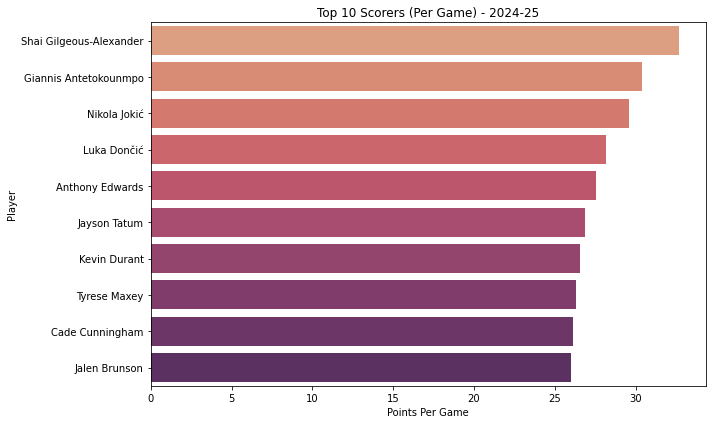

In [15]:
# Sort top 10 in points
top_scorers = df_players.sort_values('PTS_PER_GAME', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_scorers, x='PTS_PER_GAME', y='PLAYER_NAME', palette='flare')
plt.title('Top 10 Scorers (Per Game) - 2024-25')
plt.xlabel('Points Per Game')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

/var/folders/79/l_dmwqfj6v94294gmn9b0rs80000gn/T/ipykernel_81967/3508638541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players, x=stat_col, y='PLAYER_NAME', palette=color)


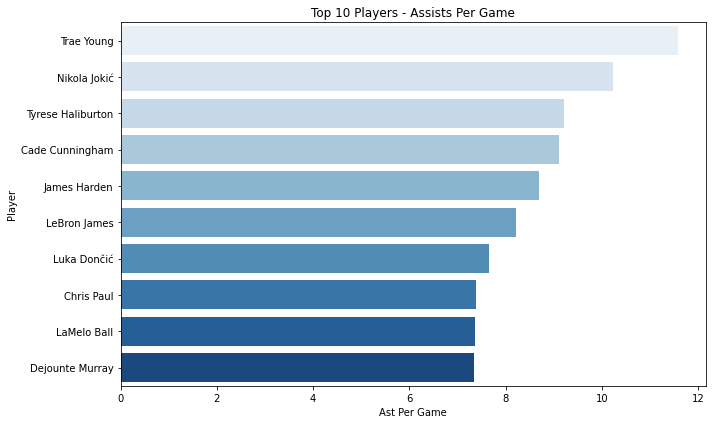

In [25]:
def plot_stat_leaderboard(df, stat_col, title, color='crest'):
    top_players = df.sort_values(stat_col, ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_players, x=stat_col, y='PLAYER_NAME', palette=color)
    plt.title(f'Top 10 Players - {title}')
    plt.xlabel(stat_col.replace("_", " ").title())
    plt.ylabel('Player')
    plt.tight_layout()
    plt.show()

# Examples:
plot_stat_leaderboard(df_players, 'AST_PER_GAME', 'Assists Per Game', color='Blues')

/var/folders/79/l_dmwqfj6v94294gmn9b0rs80000gn/T/ipykernel_81967/3508638541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players, x=stat_col, y='PLAYER_NAME', palette=color)


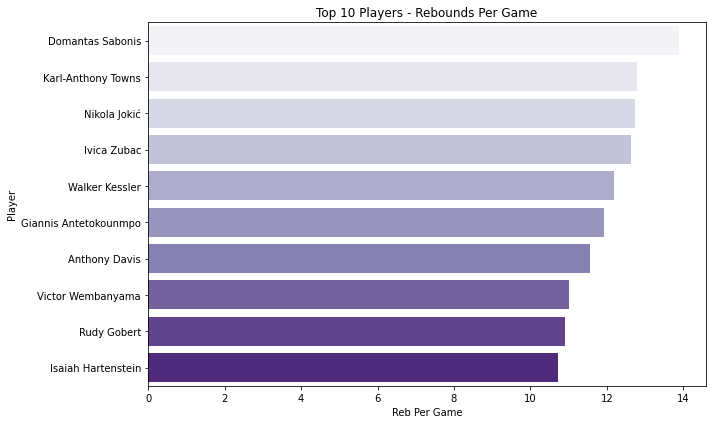

In [27]:
plot_stat_leaderboard(df_players, 'REB_PER_GAME', 'Rebounds Per Game', color='Purples')

/var/folders/79/l_dmwqfj6v94294gmn9b0rs80000gn/T/ipykernel_81967/3508638541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players, x=stat_col, y='PLAYER_NAME', palette=color)


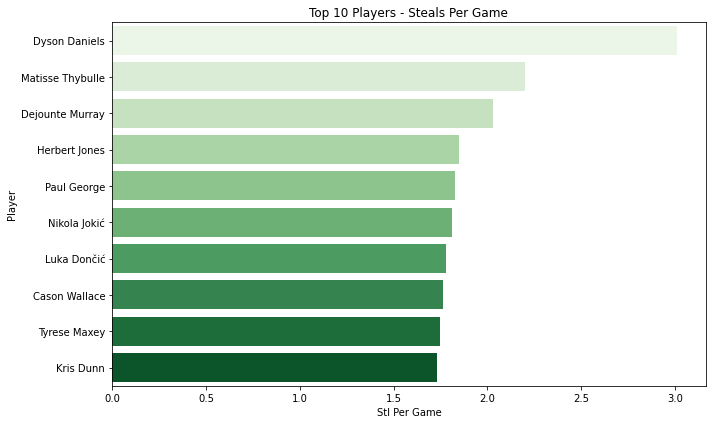

In [29]:
plot_stat_leaderboard(df_players, 'STL_PER_GAME', 'Steals Per Game', color='Greens')

/var/folders/79/l_dmwqfj6v94294gmn9b0rs80000gn/T/ipykernel_81967/3508638541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players, x=stat_col, y='PLAYER_NAME', palette=color)


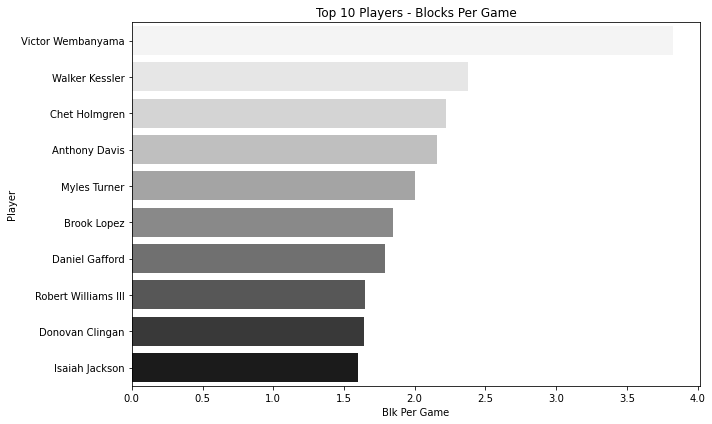

In [31]:
plot_stat_leaderboard(df_players, 'BLK_PER_GAME', 'Blocks Per Game', color='Greys')

In [37]:
#MVP
# First, re-normalize (scale each metric to 0–1)
mvp_cols = [
    'PTS_PER_GAME',
    'AST_PER_GAME',
    'REB_PER_GAME',
    'PLUS_MINUS_PER_GAME',
    'MIN_PER_GAME',
    'FG_PCT',
    'W_PCT'
]

# Drop players with too few games (we'll filter further)
df_mvp = df_players[df_players['GP'] >= 65].copy()

# Normalize columns
scaler = MinMaxScaler()
df_mvp[[col + '_SCALED' for col in mvp_cols]] = scaler.fit_transform(df_mvp[mvp_cols])

# Assign weights (feel free to tweak)
weights = {
    'PTS_PER_GAME_SCALED': 0.30,
    'AST_PER_GAME_SCALED': 0.15,
    'REB_PER_GAME_SCALED': 0.10,
    'PLUS_MINUS_PER_GAME_SCALED': 0.15,
    'MIN_PER_GAME_SCALED': 0.10,
    'FG_PCT_SCALED': 0.10,
    'W_PCT_SCALED': 0.10
}

# MVP Score = weighted sum of scaled metrics
df_mvp['MVP_SCORE'] = sum(df_mvp[col] * weight for col, weight in weights.items())

# Sort and view top MVP candidates
top_mvp = df_mvp.sort_values('MVP_SCORE', ascending=False)[
    ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS_PER_GAME', 'AST_PER_GAME', 'REB_PER_GAME', 'W_PCT', 'MVP_SCORE']
].head(10)

top_mvp.reset_index(drop=True, inplace=True)
top_mvp

,PLAYER_NAME,TEAM_ABBREVIATION,GP,PTS_PER_GAME,AST_PER_GAME,REB_PER_GAME,W_PCT,MVP_SCORE
0,Nikola Jokić,DEN,70,29.585714,10.228571,12.742857,0.657,0.844578
1,Shai Gilgeous-Alexander,OKC,76,32.684211,6.394737,4.986842,0.829,0.785714
2,Giannis Antetokounmpo,MIL,67,30.388060,6.462687,11.910448,0.597,0.759050
3,Jayson Tatum,BOS,72,26.833333,5.986111,8.652778,0.736,0.692640
4,Karl-Anthony Towns,NYK,72,24.430556,3.083333,12.777778,0.639,0.648040
5,Cade Cunningham,DET,70,26.142857,9.114286,6.071429,0.543,0.644015
6,LeBron James,LAL,70,24.428571,8.214286,7.800000,0.629,0.631031
7,Domantas Sabonis,SAC,70,19.100000,6.042857,13.885714,0.514,0.619688
8,James Harden,LAC,79,22.810127,8.696203,5.772152,0.633,0.611473
9,Anthony Edwards,MIN,79,27.556962,4.544304,5.696203,0.608,0.610413


In [335]:
df_def = leaguedashptdefend.LeagueDashPtDefend(
    season='2024-25',
    per_mode_simple='PerGame'
).get_data_frames()[0]
df_def.head()

,CLOSE_DEF_PERSON_ID,PLAYER_NAME,PLAYER_LAST_TEAM_ID,PLAYER_LAST_TEAM_ABBREVIATION,PLAYER_POSITION,AGE,GP,G,FREQ,D_FGM,D_FGA,D_FG_PCT,NORMAL_FG_PCT,PCT_PLUSMINUS
0,203999,Nikola Jokić,1610612743,DEN,C,30.0,70,70,1.0,10.04,20.51,0.490,0.495,-0.006
1,1631117,Walker Kessler,1610612762,UTA,C,23.0,58,58,1.0,8.64,19.72,0.438,0.490,-0.052
2,201572,Brook Lopez,1610612749,MIL,C,37.0,80,80,1.0,8.89,19.04,0.467,0.489,-0.022
3,1641705,Victor Wembanyama,1610612759,SAS,F-C,21.0,46,46,1.0,7.87,18.43,0.427,0.495,-0.068
4,1627826,Ivica Zubac,1610612746,LAC,C,28.0,80,80,1.0,8.36,18.26,0.458,0.492,-0.034


In [352]:
# Step 1: Rename columns
df_def = df_def.rename(columns={
    'CLOSE_DEF_PERSON_ID': 'PLAYER_ID',
    'TEAM_ABBREVIATION': 'TEAM_ABBREVIATION',
    'D_FGA': 'defended_shots',
    'D_FG_PCT': 'def_fg_pct',
    'PCT_PLUSMINUS': 'pct_plusminus'
})

# Step 2: Drop duplicates if already merged
df_def = df_def.drop(columns=['STL_PER_GAME', 'BLK_PER_GAME', 'GP'], errors='ignore')

# Step 3: Merge in STL, BLK, GP, TEAM again cleanly
df_def = df_def.merge(
    df_players[['PLAYER_ID', 'TEAM_ABBREVIATION', 'GP', 'STL_PER_GAME', 'BLK_PER_GAME']],
    on='PLAYER_ID',
    how='left'
)

# Filter for eligibility
df_def = df_def[(df_def['defended_shots'] >= 5) & (df_def['GP'] >= 65)].copy()

# Invert FG% for scoring
df_def['neg_def_fg_pct'] = -df_def['def_fg_pct']

# Normalize
scaler = MinMaxScaler()
to_scale = ['defended_shots', 'neg_def_fg_pct', 'pct_plusminus', 'STL_PER_GAME', 'BLK_PER_GAME']
df_def[[col.lower() + '_scaled' for col in to_scale]] = scaler.fit_transform(df_def[to_scale])

# Weighted score
df_def['dpoy_score'] = (
    df_def['defended_shots_scaled'] * 0.20 +
    df_def['neg_def_fg_pct_scaled'] * 0.20 +
    df_def['pct_plusminus_scaled'] * 0.30 +
    df_def['stl_per_game_scaled'] * 0.15 +
    df_def['blk_per_game_scaled'] * 0.15
)

# Top 10 DPOY
top_dpoy = df_def.sort_values('dpoy_score', ascending=False)[
    ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'defended_shots', 'def_fg_pct',
     'pct_plusminus', 'STL_PER_GAME', 'BLK_PER_GAME', 'dpoy_score']
].head(10).reset_index(drop=True)

top_dpoy

,PLAYER_NAME,TEAM_ABBREVIATION,GP,defended_shots,def_fg_pct,pct_plusminus,STL_PER_GAME,BLK_PER_GAME,dpoy_score
0,Dyson Daniels,ATL,76,15.04,0.486,0.015,3.013158,0.723684,0.576137
1,Brook Lopez,MIL,80,19.04,0.467,-0.022,0.625000,1.850000,0.539369
2,Nikola Jokić,DEN,70,20.51,0.490,-0.006,1.814286,0.642857,0.529774
3,Evan Mobley,CLE,71,17.15,0.445,-0.033,0.859155,1.591549,0.518062
4,Myles Turner,IND,72,14.93,0.486,-0.008,0.750000,2.000000,0.503922
5,Alex Sarr,WAS,67,17.70,0.508,0.008,0.656716,1.507463,0.496323
6,Jamal Murray,DEN,67,16.46,0.477,0.014,1.358209,0.492537,0.495880
7,Rudy Gobert,MIN,72,17.79,0.458,-0.033,0.777778,1.444444,0.492432
8,Josh Hart,NYK,77,15.46,0.484,0.019,1.545455,0.350649,0.481942
9,Alperen Sengun,HOU,76,17.76,0.471,-0.014,1.105263,0.802632,0.478452


In [347]:
# Load full draft history
draft_history = drafthistory.DraftHistory()
df_draft = draft_history.get_data_frames()[0]

# Filter to just 2024 draft class
df_draft_2024 = df_draft[df_draft['SEASON'] == '2024'].copy()

# Get 2024 rookie player IDs
rookie_ids = df_draft_2024['PERSON_ID'].unique()

In [224]:
df_roy = df_players[
    (df_players['PLAYER_ID'].isin(rookie_ids)) &
    (df_players['GP'] >= 65)
].copy()

# Normalize key stats
roy_cols = ['PTS_PER_GAME', 'AST_PER_GAME', 'REB_PER_GAME', 'PLUS_MINUS_PER_GAME']
scaler = MinMaxScaler()
df_roy[[col + '_SCALED' for col in roy_cols]] = scaler.fit_transform(df_roy[roy_cols])

# Weights (can be adjusted)
roy_weights = {
    'PTS_PER_GAME_SCALED': 0.4,
    'AST_PER_GAME_SCALED': 0.2,
    'REB_PER_GAME_SCALED': 0.2,
    'PLUS_MINUS_PER_GAME_SCALED': 0.2
}

df_roy['roy_score'] = sum(df_roy[col] * weight for col, weight in roy_weights.items())

# Rank top 10 rookies
top_roy = df_roy.sort_values('roy_score', ascending=False)[
    ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS_PER_GAME', 'AST_PER_GAME', 'REB_PER_GAME', 'PLUS_MINUS_PER_GAME', 'roy_score']
].head(10).reset_index(drop=True)

top_roy

,PLAYER_NAME,TEAM_ABBREVIATION,GP,PTS_PER_GAME,AST_PER_GAME,REB_PER_GAME,PLUS_MINUS_PER_GAME,roy_score
0,Stephon Castle,SAS,81,14.691358,4.098765,3.666667,-2.950617,0.694826
1,Alex Sarr,WAS,67,12.970149,2.402985,6.492537,-8.149254,0.548183
2,Zach Edey,MEM,66,9.242424,0.984848,8.303030,2.484848,0.543497
3,Zaccharie Risacher,ATL,75,12.560000,1.226667,3.573333,-1.613333,0.506361
4,Jaylen Wells,MEM,79,10.417722,1.708861,3.392405,2.354430,0.479564
5,Isaiah Collier,UTA,71,8.661972,6.281690,3.309859,-5.676056,0.426437
6,Kyle Filipowski,UTA,72,9.583333,1.944444,6.111111,-5.083333,0.406197
7,Yves Missi,NOP,73,9.109589,1.356164,8.232877,-7.041096,0.392505
8,Bub Carrington,WAS,82,9.841463,4.439024,4.158537,-9.731707,0.375456
9,Donovan Clingan,POR,67,6.507463,1.149254,7.865672,-0.029851,0.362719


In [232]:
# Load clutch stats
clutch_stats = leaguedashplayerclutch.LeagueDashPlayerClutch(
    season='2024-25',
    clutch_time='Last 5 Minutes',
    ahead_behind='Ahead or Behind',
    point_diff='5',
    per_mode_detailed='PerGame',
    measure_type_detailed_defense='Base'
)

df_clutch = clutch_stats.get_data_frames()[0]

# Filter players with at least 20 clutch games
df_clutch = df_clutch[df_clutch['GP'] >= 20].copy()

# Normalize relevant stats
scaler = MinMaxScaler()
df_clutch[['PTS_scaled', 'FG_PCT_scaled', 'PLUS_MINUS_scaled']] = scaler.fit_transform(
    df_clutch[['PTS', 'FG_PCT', 'PLUS_MINUS']]
)

# Weighted clutch score
df_clutch['clutch_score'] = (
    df_clutch['PTS_scaled'] * 0.5 +
    df_clutch['FG_PCT_scaled'] * 0.3 +
    df_clutch['PLUS_MINUS_scaled'] * 0.2
)

# Top 10 clutch performers
top_clutch = df_clutch.sort_values('clutch_score', ascending=False)[
    ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS', 'FG_PCT', 'PLUS_MINUS', 'clutch_score']
].head(10).reset_index(drop=True)

top_clutch

,PLAYER_NAME,TEAM_ABBREVIATION,GP,PTS,FG_PCT,PLUS_MINUS,clutch_score
0,Jalen Brunson,NYK,28,5.6,0.515,0.8,0.802817
1,Nikola Jokić,DEN,33,4.2,0.562,1.8,0.728586
2,Tyrese Maxey,PHI,24,4.9,0.466,-0.4,0.674997
3,Darius Garland,CLE,34,3.0,0.534,2.5,0.627663
4,Bennedict Mathurin,IND,26,2.7,0.568,2.0,0.599181
5,Norman Powell,LAC,24,3.2,0.538,1.0,0.598059
6,Tyrese Haliburton,IND,32,3.1,0.471,2.1,0.594011
7,Domantas Sabonis,SAC,35,1.8,0.793,1.1,0.591481
8,Trae Young,ATL,38,4.0,0.364,0.9,0.587110
9,Jamal Murray,DEN,29,2.6,0.548,2.1,0.583865


In [246]:
# Get bench-only players
bench_stats = leaguedashplayerstats.LeagueDashPlayerStats(
    season='2024-25',
    starter_bench_nullable='Bench',
    per_mode_detailed='PerGame'
)

df_bench = bench_stats.get_data_frames()[0]
df_bench.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK
0,1630639,A.J. Lawson,A.J.,1610612761,TOR,24.0,24,13,11,0.542,...,197,105,160,82,81,276,130,20,3,117
1,1631260,AJ Green,AJ,1610612749,MIL,25.0,66,39,27,0.591,...,368,398,47,241,129,36,207,100,3,161
2,1642358,AJ Johnson,AJ,1610612764,WAS,20.0,18,5,13,0.278,...,400,113,327,293,242,376,289,100,3,291
3,203932,Aaron Gordon,Aaron,1610612743,DEN,29.0,9,6,3,0.667,...,220,89,274,36,50,49,88,100,3,83
4,1628988,Aaron Holiday,Aaron,1610612745,HOU,28.0,59,38,21,0.644,...,260,308,301,240,235,94,303,100,3,288


In [252]:
# Filter: must play 65+ games total
df_bench = df_bench[df_bench['GP'] >= 65].copy()

# Normalize scoring and playmaking impact
to_scale = ['PTS', 'AST', 'REB', 'PLUS_MINUS']
df_bench[[col + '_scaled' for col in to_scale]] = scaler.fit_transform(df_bench[to_scale])

# Weighted 6MOY score
df_bench['sixth_score'] = (
    df_bench['PTS_scaled'] * 0.4 +
    df_bench['AST_scaled'] * 0.2 +
    df_bench['REB_scaled'] * 0.2 +
    df_bench['PLUS_MINUS_scaled'] * 0.2
)

# Top 10 sixth men
top_sixth = df_bench.sort_values('sixth_score', ascending=False)[
    ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS', 'AST', 'REB', 'PLUS_MINUS', 'sixth_score']
].head(10).reset_index(drop=True)

top_sixth

,PLAYER_NAME,TEAM_ABBREVIATION,GP,PTS,AST,REB,PLUS_MINUS,sixth_score
0,Payton Pritchard,BOS,77,14.0,3.3,3.8,5.6,0.845630
1,Ty Jerome,CLE,67,12.0,3.3,2.5,3.7,0.670035
2,Kevin Porter Jr.,MIL,71,9.8,3.3,3.6,0.8,0.563011
3,Nickeil Alexander-Walker,MIN,72,9.0,2.6,3.1,4.2,0.558508
4,Keldon Johnson,SAS,77,12.7,1.6,4.8,-2.8,0.554846
5,T.J. McConnell,IND,78,9.1,4.5,2.5,-0.5,0.518095
6,Anthony Black,ORL,68,9.5,3.1,2.9,1.0,0.517422
7,Georges Niang,ATL,76,9.8,1.4,3.4,2.2,0.495328
8,Gary Trent Jr.,MIL,65,11.1,1.2,2.3,1.9,0.482120
9,Obi Toppin,IND,75,10.2,1.6,3.9,-0.9,0.467346


In [258]:
# Get 2023–24 season data
stats_last = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24')
df_last_season = stats_last.get_data_frames()[0]

# Keep only needed columns
df_last_season = df_last_season[['PLAYER_ID', 'PTS', 'AST', 'REB', 'GP', 'MIN']]
df_last_season.rename(columns={
    'PTS': 'PTS_PREV',
    'AST': 'AST_PREV',
    'REB': 'REB_PREV',
    'GP': 'GP_PREV',
    'MIN': 'MIN_PREV'
}, inplace=True)
df_last_season.head()

,PLAYER_ID,PTS_PREV,AST_PREV,REB_PREV,GP_PREV,MIN_PREV
0,1630639,136,20,50,42,310.900000
1,1631260,252,30,64,56,614.281667
2,1631100,48,5,18,20,170.730000
3,203932,1013,259,471,73,2296.810000
4,1628988,514,140,123,78,1269.296667


In [262]:
# Step 3: Merge with current season data (assume df_players already exists for 2024–25)
df_mip = df_players.merge(df_last_season, on='PLAYER_ID', how='inner')

# Step 4: Filter to 65+ games this year and last year ≥ 10 games
df_mip = df_mip[(df_mip['GP'] >= 65) & (df_mip['GP_PREV'] >= 10)].copy()

# Step 5: Calculate per-game improvements
df_mip['PTS_DIFF'] = (df_mip['PTS'] / df_mip['GP']) - (df_mip['PTS_PREV'] / df_mip['GP_PREV'])
df_mip['AST_DIFF'] = (df_mip['AST'] / df_mip['GP']) - (df_mip['AST_PREV'] / df_mip['GP_PREV'])
df_mip['MIN_DIFF'] = (df_mip['MIN'] / df_mip['GP']) - (df_mip['MIN_PREV'] / df_mip['GP_PREV'])

# Step 6: Normalize the improvement metrics
scaler = MinMaxScaler()
df_mip[['PTS_DIFF_SCALED', 'AST_DIFF_SCALED', 'MIN_DIFF_SCALED']] = scaler.fit_transform(
    df_mip[['PTS_DIFF', 'AST_DIFF', 'MIN_DIFF']]
)

# Step 7: Score players
df_mip['mip_score'] = (
    df_mip['PTS_DIFF_SCALED'] * 0.5 +
    df_mip['AST_DIFF_SCALED'] * 0.2 +
    df_mip['MIN_DIFF_SCALED'] * 0.3
)

# Step 8: Top 10 Most Improved
top_mip = df_mip.sort_values('mip_score', ascending=False)[
    ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS_DIFF', 'AST_DIFF', 'MIN_DIFF', 'mip_score']
].head(10).reset_index(drop=True)

top_mip

,PLAYER_NAME,TEAM_ABBREVIATION,GP,PTS_DIFF,AST_DIFF,MIN_DIFF,mip_score
0,Dyson Daniels,ATL,76,8.315142,1.693054,11.560283,0.922414
1,Christian Braun,DEN,79,8.100648,0.985181,13.675795,0.914092
2,Quentin Grimes,PHI,75,7.520784,1.745882,6.744272,0.840583
3,Max Christie,DAL,78,5.363758,0.976272,13.176744,0.820359
4,Davion Mitchell,MIA,74,2.682057,3.044294,12.103071,0.801152
5,Naji Marshall,DAL,69,6.185771,1.075099,8.765479,0.796786
6,Anthony Black,ORL,78,4.856187,1.758082,7.319614,0.763020
7,Amen Thompson,HOU,69,4.509584,1.211547,9.856719,0.761800
8,Jalen Wilson,BKN,79,4.504268,0.788931,10.259414,0.750296
9,Ivica Zubac,LAC,80,5.073529,1.307353,6.413262,0.741636


In [264]:
team_colors = {
    'ATL': '#E03A3E', 'BOS': '#007A33', 'BKN': '#000000', 'CHA': '#1D1160',
    'CHI': '#CE1141', 'CLE': '#6F263D', 'DAL': '#00538C', 'DEN': '#0E2240',
    'DET': '#C8102E', 'GSW': '#1D428A', 'HOU': '#CE1141', 'IND': '#002D62',
    'LAC': '#C8102E', 'LAL': '#552583', 'MEM': '#5D76A9', 'MIA': '#98002E',
    'MIL': '#00471B', 'MIN': '#0C2340', 'NOP': '#0C2340', 'NYK': '#F58426',
    'OKC': '#007AC1', 'ORL': '#0077C0', 'PHI': '#006BB6', 'PHX': '#1D1160',
    'POR': '#E03A3E', 'SAC': '#5A2D81', 'SAS': '#C4CED4', 'TOR': '#CE1141',
    'UTA': '#002B5C', 'WAS': '#002B5C'
}

In [304]:
team_logos = {
    'ATL': 'https://a.espncdn.com/i/teamlogos/nba/500/atl.png',
    'BOS': 'https://a.espncdn.com/i/teamlogos/nba/500/bos.png',
    'BKN': 'https://a.espncdn.com/i/teamlogos/nba/500/bkn.png',
    'CHA': 'https://a.espncdn.com/i/teamlogos/nba/500/cha.png',
    'CHI': 'https://a.espncdn.com/i/teamlogos/nba/500/chi.png',
    'CLE': 'https://a.espncdn.com/i/teamlogos/nba/500/cle.png',
    'DAL': 'https://a.espncdn.com/i/teamlogos/nba/500/dal.png',
    'DEN': 'https://a.espncdn.com/i/teamlogos/nba/500/den.png',
    'DET': 'https://a.espncdn.com/i/teamlogos/nba/500/det.png',
    'GSW': 'https://a.espncdn.com/i/teamlogos/nba/500/gs.png',
    'HOU': 'https://a.espncdn.com/i/teamlogos/nba/500/hou.png',
    'IND': 'https://a.espncdn.com/i/teamlogos/nba/500/ind.png',
    'LAC': 'https://a.espncdn.com/i/teamlogos/nba/500/lac.png',
    'LAL': 'https://a.espncdn.com/i/teamlogos/nba/500/lal.png',
    'MEM': 'https://a.espncdn.com/i/teamlogos/nba/500/mem.png',
    'MIA': 'https://a.espncdn.com/i/teamlogos/nba/500/mia.png',
    'MIL': 'https://a.espncdn.com/i/teamlogos/nba/500/mil.png',
    'MIN': 'https://a.espncdn.com/i/teamlogos/nba/500/min.png',
    'NOP': 'https://a.espncdn.com/i/teamlogos/nba/500/no.png',
    'NYK': 'https://a.espncdn.com/i/teamlogos/nba/500/ny.png',
    'OKC': 'https://a.espncdn.com/i/teamlogos/nba/500/okc.png',
    'ORL': 'https://a.espncdn.com/i/teamlogos/nba/500/orl.png',
    'PHI': 'https://a.espncdn.com/i/teamlogos/nba/500/phi.png',
    'PHX': 'https://a.espncdn.com/i/teamlogos/nba/500/phx.png',
    'POR': 'https://a.espncdn.com/i/teamlogos/nba/500/por.png',
    'SAC': 'https://a.espncdn.com/i/teamlogos/nba/500/sac.png',
    'SAS': 'https://a.espncdn.com/i/teamlogos/nba/500/sas.png',
    'TOR': 'https://a.espncdn.com/i/teamlogos/nba/500/tor.png',
    'UTA': 'https://a.espncdn.com/i/teamlogos/nba/500/uta.png',
    'WAS': 'https://a.espncdn.com/i/teamlogos/nba/500/wsh.png'
}

In [354]:
top_mvp['team_color'] = top_mvp['TEAM_ABBREVIATION'].map(team_colors)
top_dpoy['team_color'] = top_dpoy['TEAM_ABBREVIATION'].map(team_colors)
top_roy['team_color'] = top_roy['TEAM_ABBREVIATION'].map(team_colors)
top_clutch['team_color'] = top_clutch['TEAM_ABBREVIATION'].map(team_colors)
top_sixth['team_color'] = top_sixth['TEAM_ABBREVIATION'].map(team_colors)
top_mip['team_color'] = top_mip['TEAM_ABBREVIATION'].map(team_colors)

In [370]:
def get_logo(team_abbr):
    try:
        url = team_logos[team_abbr]
        response = requests.get(url)
        logo = Image.open(BytesIO(response.content))
        return OffsetImage(logo, zoom=0.06)
    except:
        return None

def plot_award_with_logos(df, score_col, title):
    plt.figure(figsize=(12, 6), dpi=300)
    ax = plt.gca()
    
    bars = ax.barh(df['PLAYER_NAME'], df[score_col], color=df['team_color'])
    ax.invert_yaxis()

    # Add team logos at end of each bar
    for bar, (_, row) in zip(bars, df.iterrows()):
        img = get_logo(row['TEAM_ABBREVIATION'])
        if img:
            # Get bar end x position
            x = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2

            # Adjust horizontal placement slightly to right of the bar
            ab = AnnotationBbox(img, (x + 0.02, y),  # +0.02 for space
                                frameon=False,
                                box_alignment=(0, 0.5),
                                xycoords='data',
                                pad=0)
            ax.add_artist(ab)

    ax.set_xlabel(score_col.replace('_', ' ').title())
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

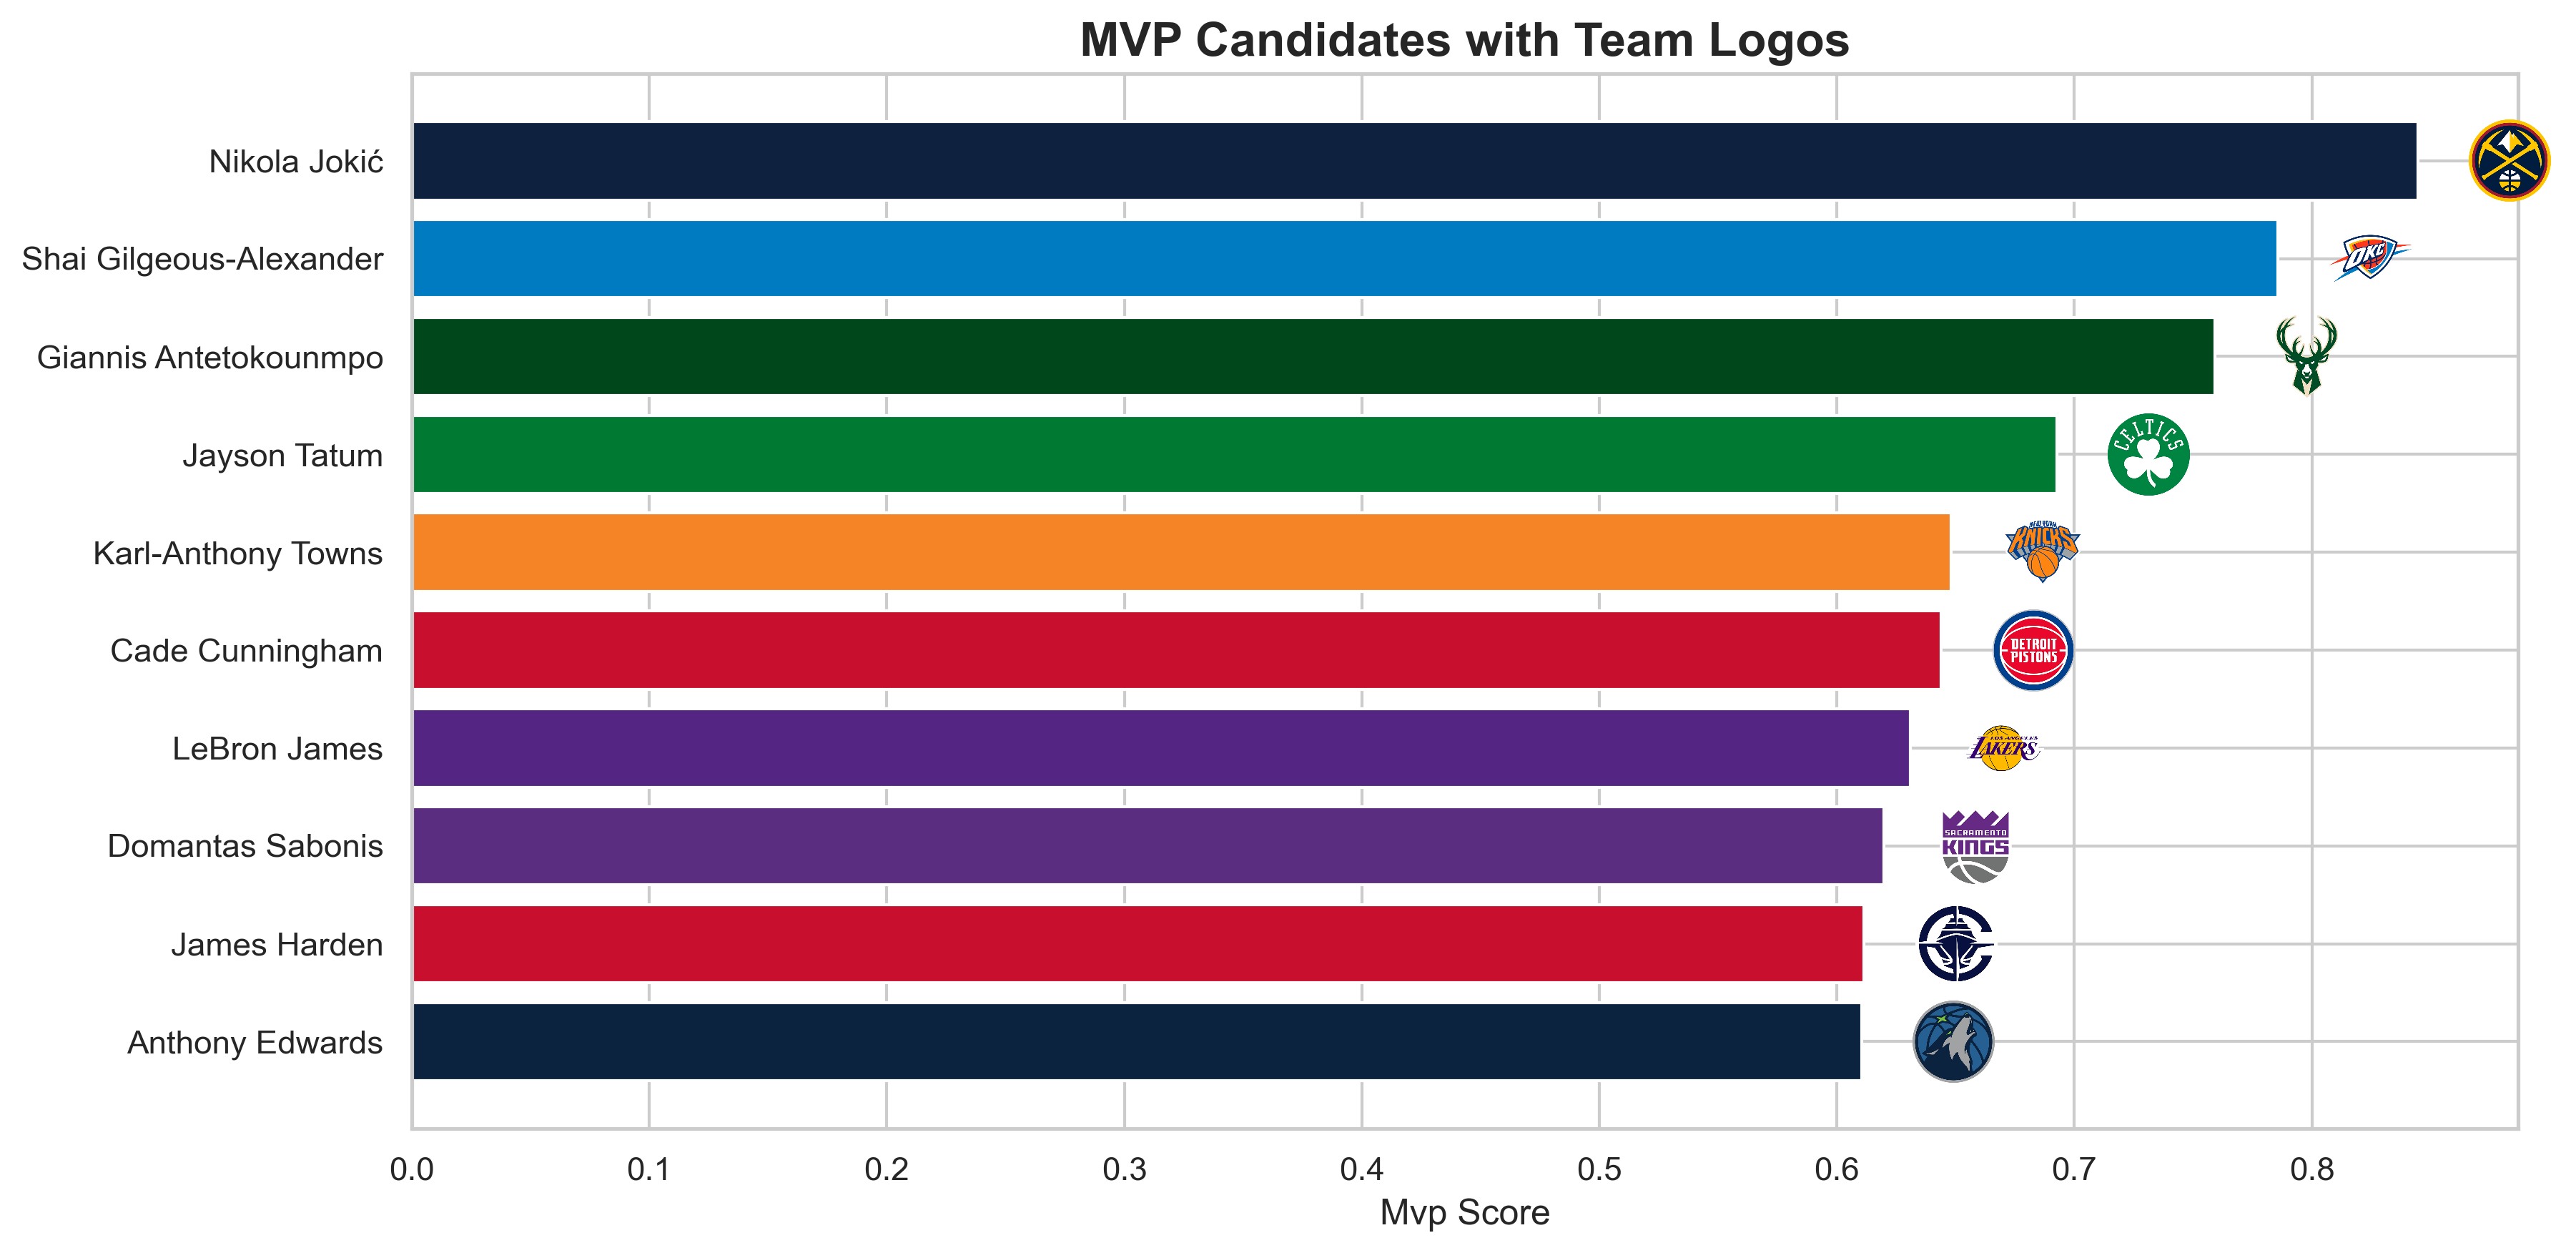

In [372]:
plot_award_with_logos(top_mvp, 'MVP_SCORE', 'MVP Candidates with Team Logos')

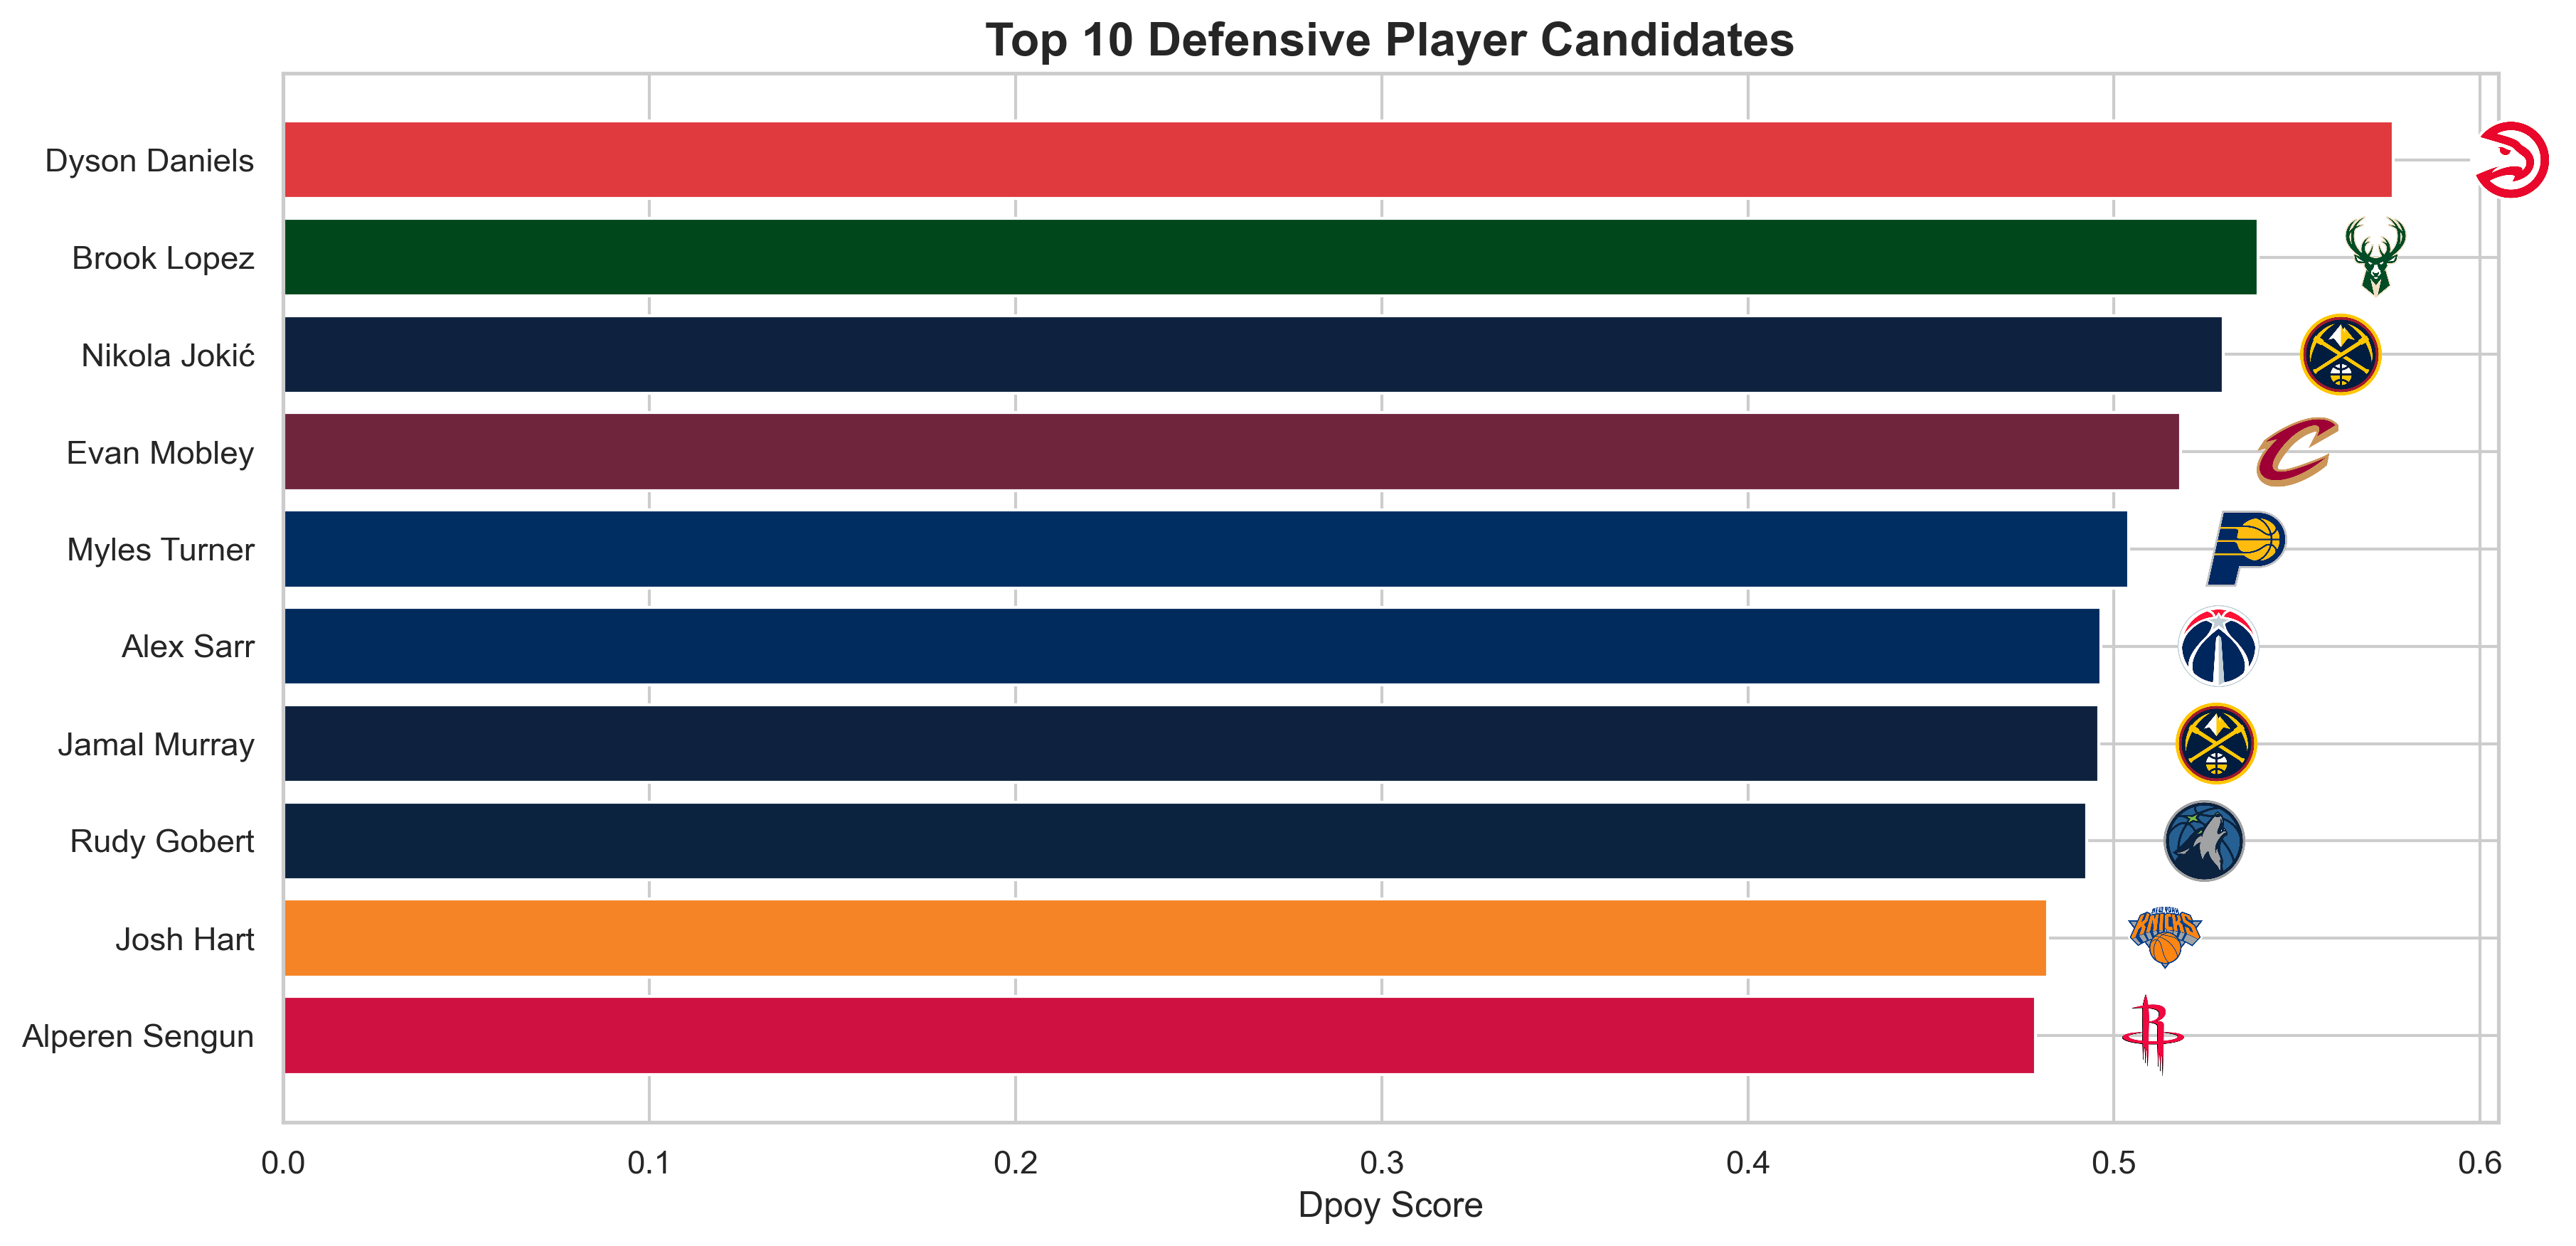

In [374]:
plot_award_with_logos(top_dpoy, 'dpoy_score', 'Top 10 Defensive Player Candidates')

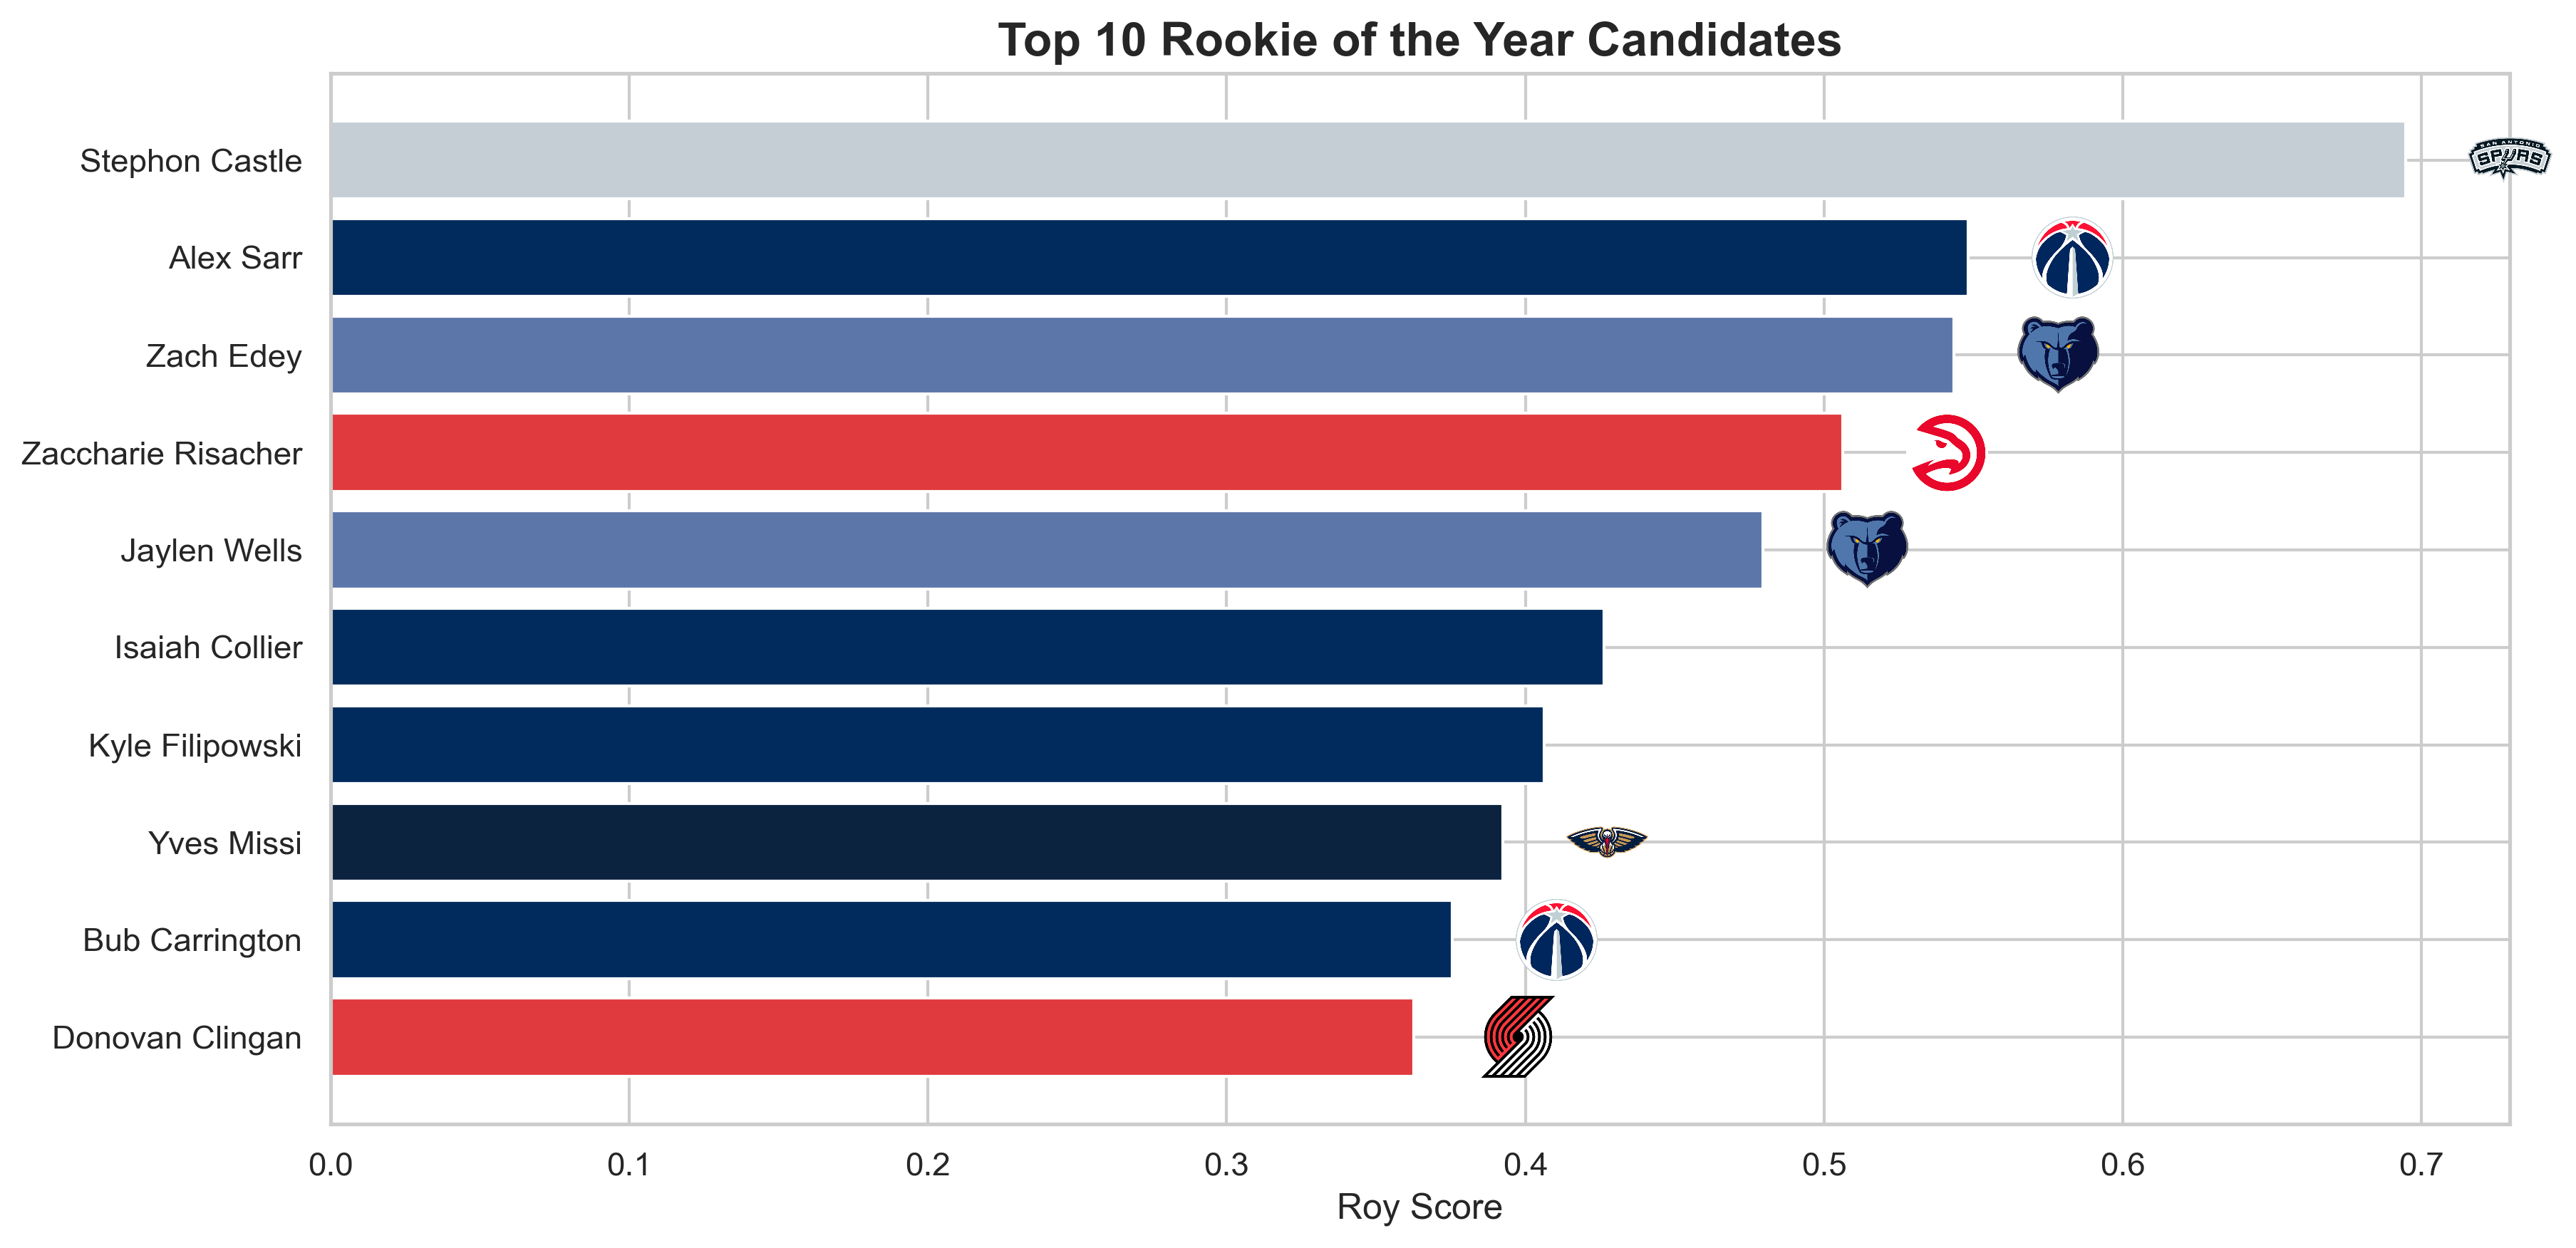

In [376]:
plot_award_with_logos(top_roy, 'roy_score', 'Top 10 Rookie of the Year Candidates')

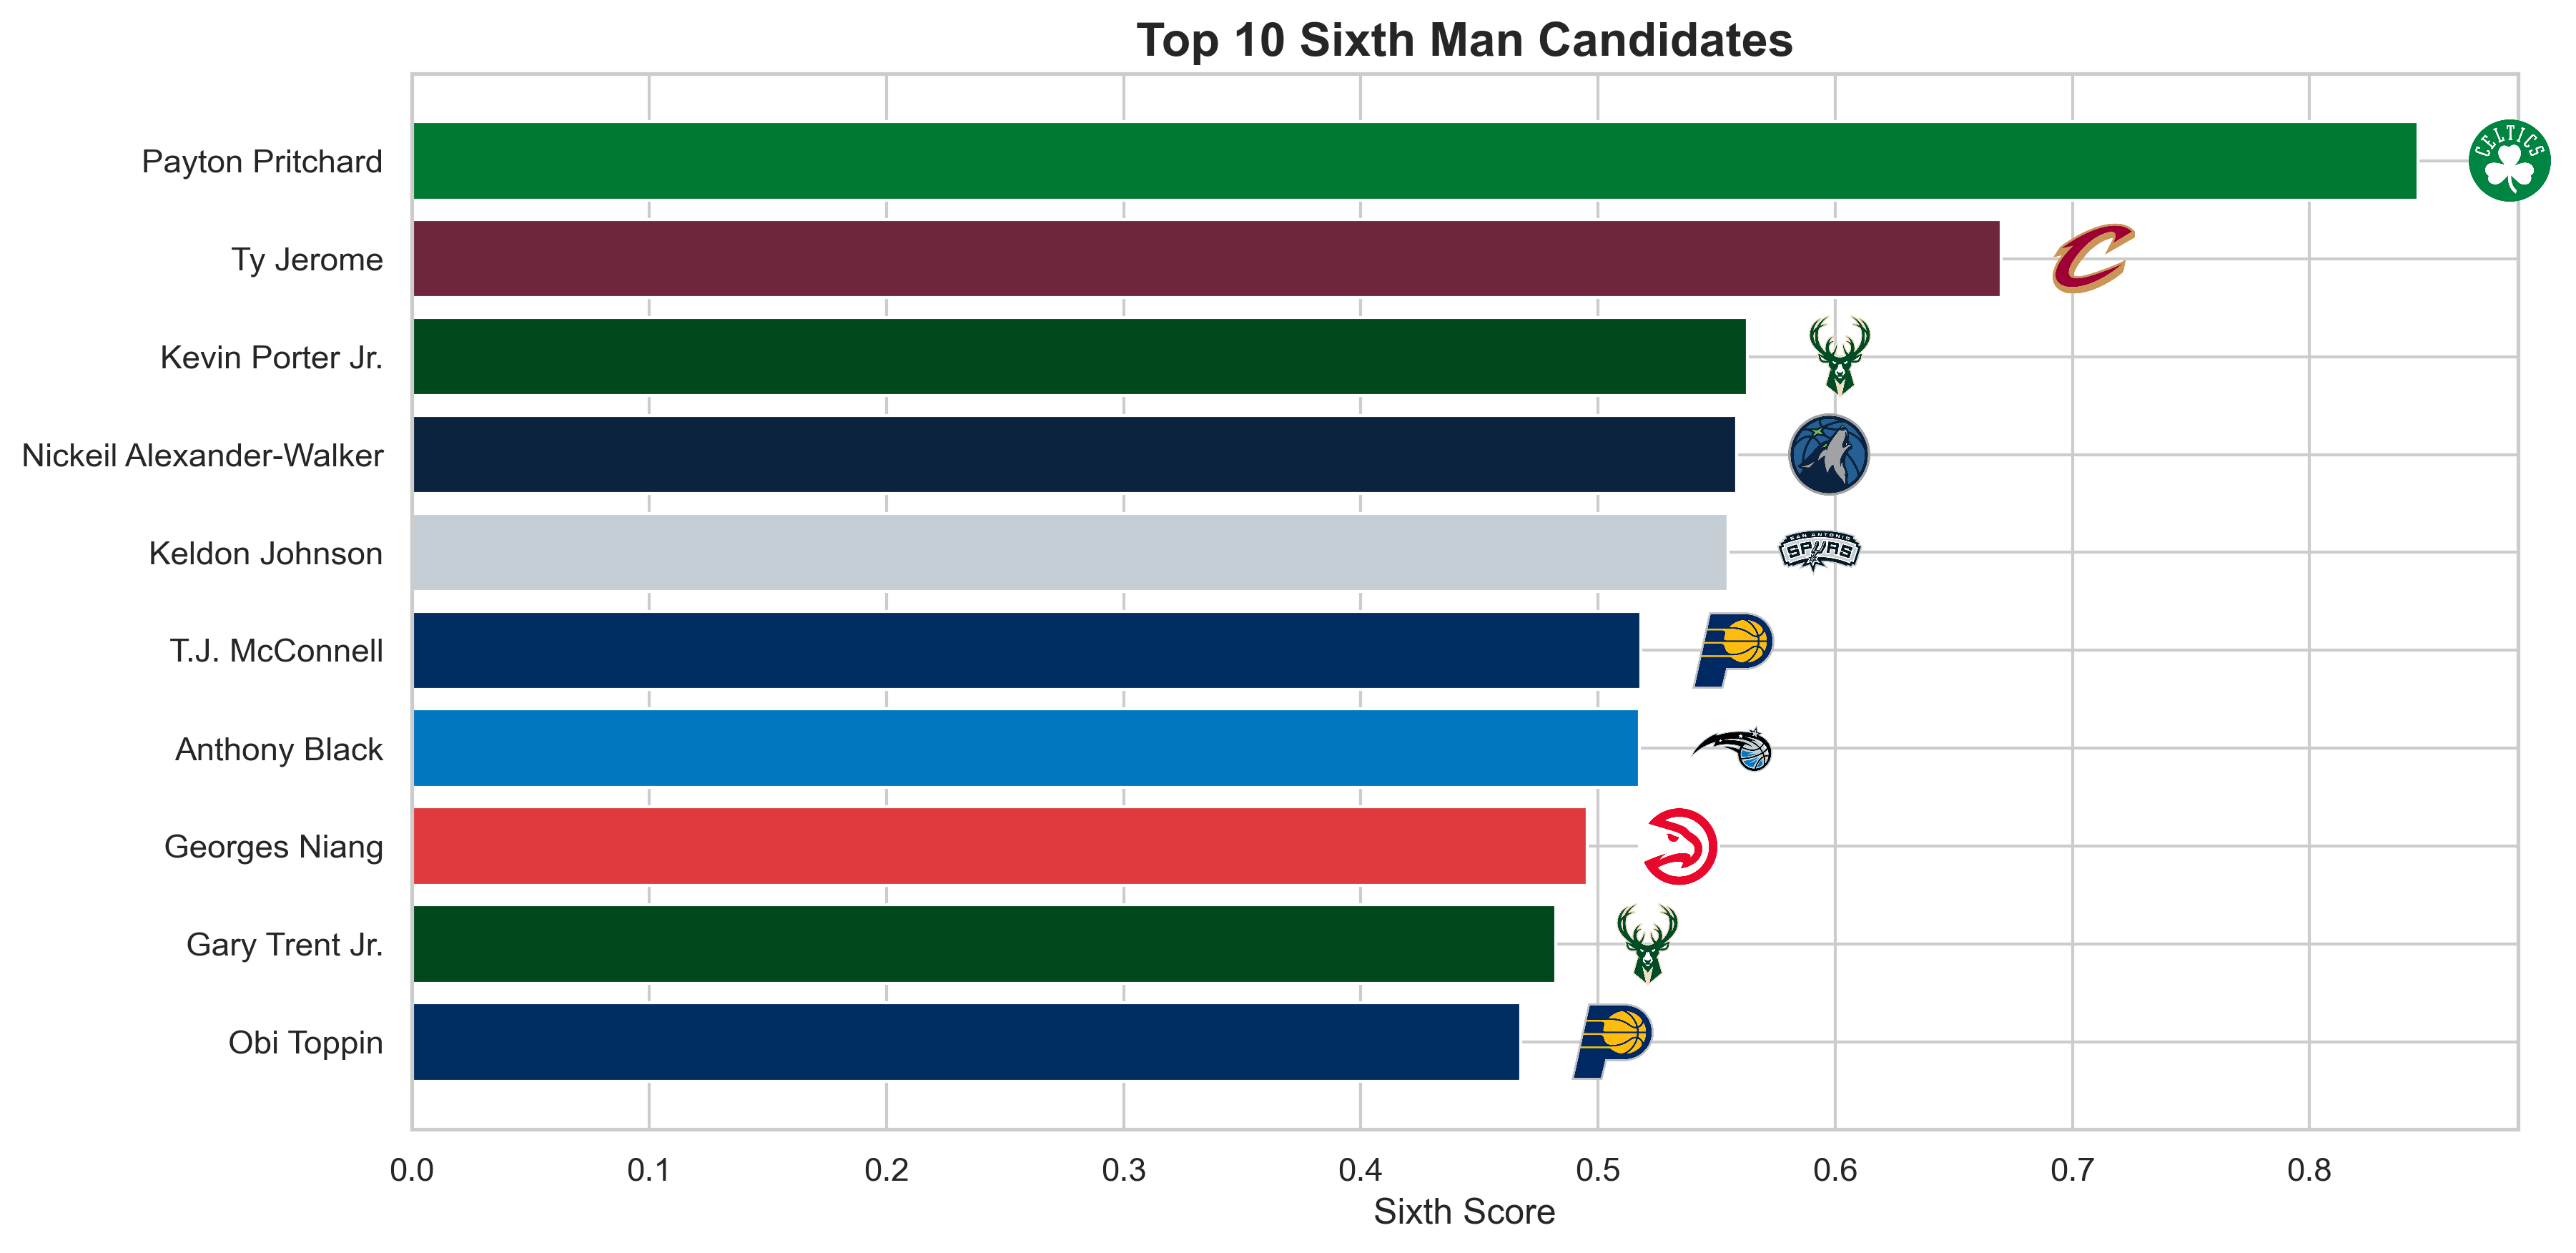

In [378]:
plot_award_with_logos(top_sixth, 'sixth_score', 'Top 10 Sixth Man Candidates')

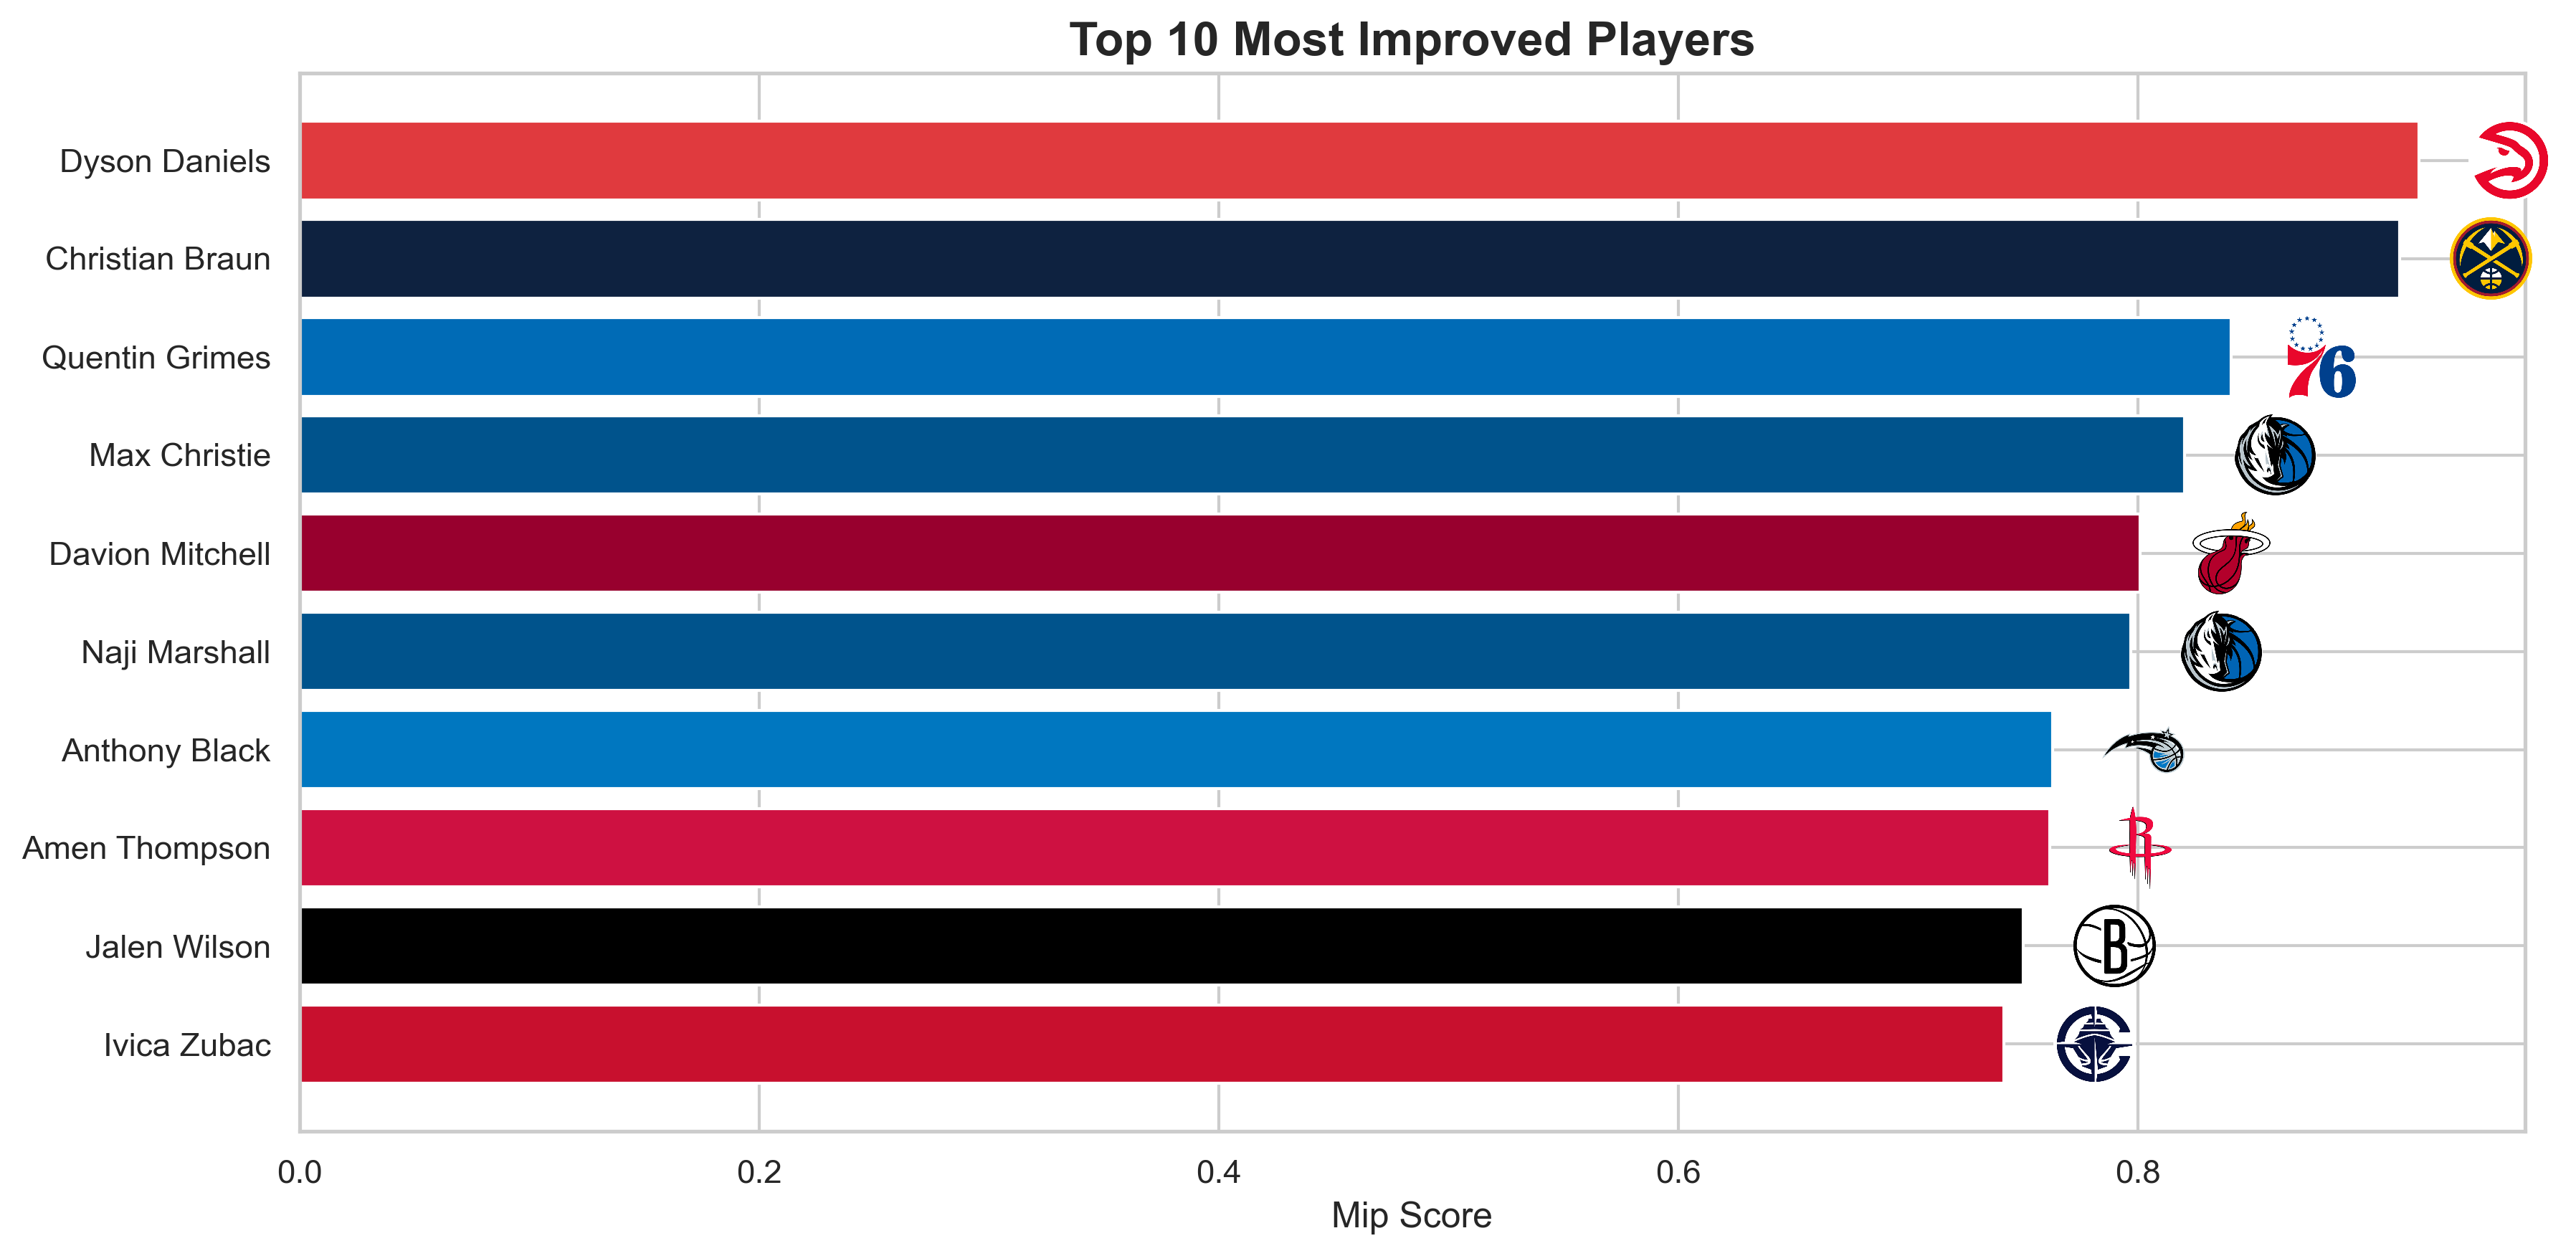

In [380]:
plot_award_with_logos(top_mip, 'mip_score', 'Top 10 Most Improved Players')